In [1]:
reset -fs

# Import packages

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base            import BaseEstimator
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder 
from sklearn import set_config
import warnings
set_config(display='diagram')
warnings.filterwarnings('ignore')

# Load data file

In [3]:
bike_df=pd.read_csv("SeoulBikeData.csv")

# Check data type

In [4]:
bike_df.dtypes

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(�C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(�C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

# Extract year and month from Date

In [5]:
bike_df['year'] = pd.DatetimeIndex(bike_df['Date']).year
bike_df['month'] = pd.DatetimeIndex(bike_df['Date']).month


# Rename Columns

In [6]:
bike_df.rename(columns={'Rented Bike Count':'Count', 
                        'Temperature(�C)':'Temp', 
                        'Humidity(%)':'Hum', 
                        'Wind speed (m/s)': 'Wind_speed', 
                        'Visibility (10m)':'Visi',
                        'Dew point temperature(�C)':'Dew_point_temp',
                        'Solar Radiation (MJ/m2)':'Solar_rad', 
                        'Rainfall(mm)':'Rainfall',
                        'Snowfall (cm)': 'Snowfall',
                        'Functioning Day': 'Functioning_day',
                        },inplace=True)

# Check if there exist missing values in dataset

In [7]:
#Missing values in dataset
bike_df.isnull().sum()

Date               0
Count              0
Hour               0
Temp               0
Hum                0
Wind_speed         0
Visi               0
Dew_point_temp     0
Solar_rad          0
Rainfall           0
Snowfall           0
Seasons            0
Holiday            0
Functioning_day    0
year               0
month              0
dtype: int64

In [8]:
# display dataframe 
bike_df

,Date,Count,Hour,Temp,Hum,Wind_speed,Visi,Dew_point_temp,Solar_rad,Rainfall,Snowfall,Seasons,Holiday,Functioning_day,year,month
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018,11
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018,11
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018,11
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,2018,11


# Heat map for correlation matrix of attributes

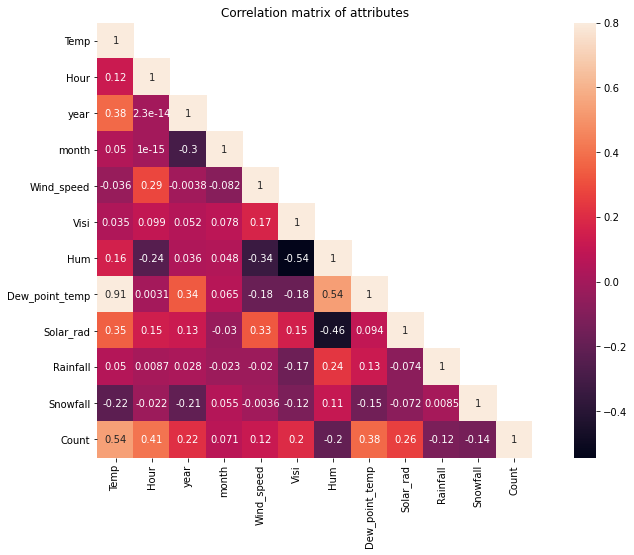

In [9]:
correMtr=bike_df[["Temp","Hour", "year", "month","Wind_speed","Visi","Hum","Dew_point_temp", "Solar_rad","Rainfall","Snowfall", "Count"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False

fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

We can observe from the heat map above that temperature, hour, year, visibility, dew point temperature, and solar radiation has relatively strong correlation with rented bike counts. The humidity has relatively strong negative correlation with count

# Barplot for Year distribution of counts

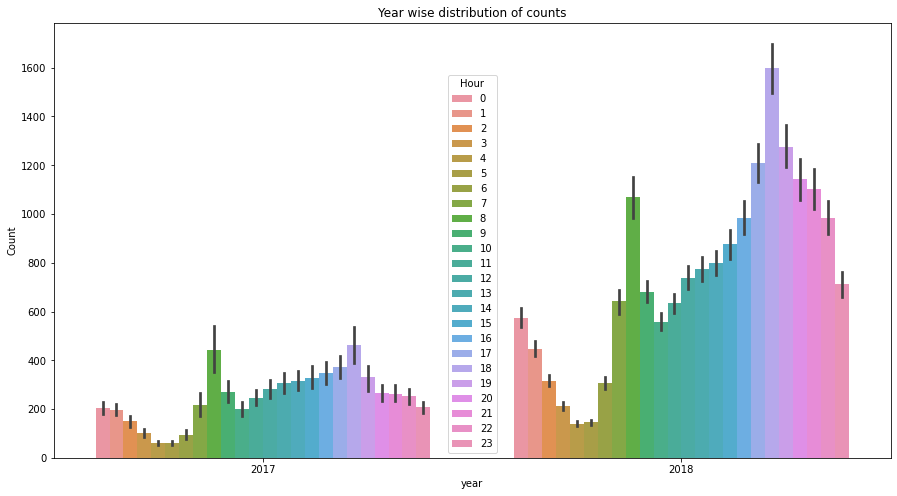

In [10]:
fig,ax=plt.subplots(figsize=(15,8))
sns.barplot(data=bike_df,x='year',y='Count',hue='Hour')
ax.set_title('Year wise distribution of counts')
plt.show()

We can see from this plot that the overall bike sharing demands in 2018 is higher than 2017.

And there exists a clear pattern of demands trend based on hours of day.

# Barplot for seasons distribution of counts

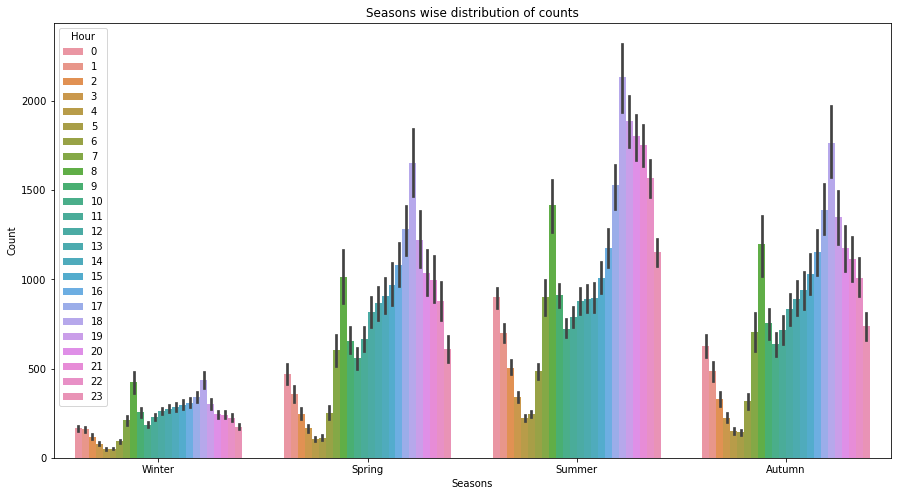

In [11]:
fig,ax=plt.subplots(figsize=(15,8))
sns.barplot(data=bike_df,x='Seasons',y='Count',hue='Hour')
ax.set_title('Seasons wise distribution of counts')
plt.show()

For each season, the bike sharing demands still influenced by the hours and have repetitive pattern.

Also, the overall demands count start to grow in winter linearly and reach its peak at summer and then start to going downhill in autumn.

# Change Date to datetime and change year, Seasons, Hoilday, and Functioning day to category type

In [12]:
bike_df['Date']=pd.to_datetime(bike_df.Date)
bike_df['year']=bike_df.year.astype('category')
bike_df['Seasons']=bike_df.Seasons.astype('category')
bike_df['Holiday']=bike_df.Holiday.astype('category')
bike_df['Functioning_day']=bike_df.Functioning_day.astype('category')

# Helper class (you do not have to use it)

In [13]:
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

# convert Seasons, Hoilday, Functioning_day, and year to dummies variables

In [14]:
cat_attributes=['Seasons','Holiday','Functioning_day','year']
bike_df=pd.get_dummies(bike_df,columns=cat_attributes)

# Split the dataset into the train and test data with 80% for train size and 20% for test size

In [15]:
X_train,X_test,y_train,y_test=train_test_split(bike_df.iloc[:,2:],bike_df.iloc[:,1:2],test_size=0.2, random_state=42)

# Create a pipeline for standardScaler and DummyEstimator

In [16]:
pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', DummyEstimator())
                ])

# Show evidence of automated cross validation search across algorithms and hyperparameters

In [17]:
# Create search space for RandomSearchCV
# Here I select 7 regression models in order to find the
# best model among them with best hyperparameters
search_space = [
    {
        'clf': [LinearRegression()],
    },
    {
        'clf': [GradientBoostingRegressor()],
        'clf__n_estimators': range(50, 300, 50),
        'clf__loss': ['ls', 'lad', 'huber', 'quantile'],
        'clf__criterion':['friedman_mse', 'mse', 'mae'],
        'clf__max_depth': range(50, 300, 50),
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features':['auto', 'sqrt', 'log2'],
    },
    {
        'clf': [RandomForestRegressor()],
        'clf__n_estimators': range(50, 300, 50),
        'clf__criterion': ['mse', 'mae'],
        'clf__max_depth': range(50, 300, 50),
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features':['auto', 'sqrt', 'log2']
    },
    {
        'clf': [DecisionTreeRegressor()],
        'clf__criterion':['mse', 'friedman_mse', 'mae', 'poisson'],
        'clf__splitter':['best', 'random'],
        'clf__max_depth': range(50, 300, 50),
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features':['auto', 'sqrt', 'log2']
    },
]


clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=25,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring=mean_absolute_error)

# fit the best model and find its best hyperparameters
clf_algos_rand.fit(X_train, y_train)
clf_algos_rand.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestRegressor(max_depth=250, min_samples_leaf=2,
                                       n_estimators=150))])

In [25]:
clf_algos_rand.best_estimator_[1]

RandomForestRegressor(max_depth=250, min_samples_leaf=2, n_estimators=150)

# Create pipeline for the final model

In [26]:
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestRegressor(max_depth=250, n_estimators=150,
                                       min_samples_leaf=2))])

In [28]:
y_test  = y_test.values.ravel()
pipe.fit(X_train, y_train);
y_pred  = pipe.predict(X_test)

# I use MAE as the evaluation metric here
mae = mean_absolute_error(y_test, y_pred)

# Conclusion:

The best final model is shown as below:

In [30]:
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestRegressor(max_depth=250, min_samples_leaf=2,
                                       n_estimators=150))])

- In the DecisionTreeRegressor: 

    <br> the maximum depth of decision tree is 250<br>
    <br> the n estimators is 150<br>
    <br> the min_samples_leaf is 2<br>
    

In [31]:
print(max(bike_df['Count']))

3556


In [32]:
print(min(bike_df['Count']))

0


In [33]:
print(f'MAE score: {mae:.2f}')

MAE score: 140.96


The mae score 140.96 means that on average, the forecast's distance from the true value is 140.96

Since the range of rented bike sharing demand is from 0 to 3556, mae is a good evaluation metric for my final model. 

Therefore, in a business sense, decision tree regressor helps me predict the bike sharing demands given certain features such as times, days, hours, weathers, and etc.

By asking a series of questions, the model narrows down the possible values to get confident enough to make a prediction.

If I am a bike sharing company owner/employee, then I will be able to estimate how many bike I need to provide for the customers. (allocating resources more efficiently)

# Next steps

I can try neural network and more feature engineering to see if I can further improve my prediction.